# Kay (2012) Figure 7, Panel 3

## Total low, mid, and high cloud cover CALIOP.

### Function and package imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/Common/')
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    mpl
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png
    )

from cloud_metric import Cloud_Metric
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Interpolation functions with xESMF

In [2]:
from interp_functions import *

#### Taylor plot specific imports

In [3]:
import taylor_jshaw as taylor
import matplotlib as matplotlib
import matplotlib.patches as patches

#### Stats specific imports

In [4]:
import scipy.stats as stats

#### Masking imports

In [5]:
import numpy.ma as ma

In [6]:
def get_min_max(da):
    '''
    Requires the file to have identifiable limits/null values.
    '''
    if ('valid_min' in da.attrs and 'valid_max' in da.attrs):
        _min = da.valid_min
        _min_flt = np.float(_min.split(' ')[-1])

        _max = da.valid_max
        _max_flt = np.float(_max.split(' ')[-1])
        
        return _min_flt,_max_flt
        
    elif 'valid_range' in da.attrs:       
        _min_flt = da.valid_range[0]
        _max_flt = da.valid_range[1]
    
        return _min_flt,_max_flt

In [7]:
def get_mask(da):
    '''
    Return values to mask (i.e. to use with where() after inverting).
    Requires the file to have identifiable limits/null values.
    '''
    
    _min,_max = get_min_max(da)

    # these values are True if they should be discarded, should catch Nans
    mask = np.invert(np.bitwise_and(da < _max, da > _min,))
    
    return mask

### Get CALIOP total cloud observations on their native grid (2006 files are not working)

In [10]:
caliop_obs_dir = '/glade/u/home/jonahshaw/w/obs/CALIPSO/GOCCP/2Ddata/grid_1x1_L40/'
# caliop_obs_dir = '/glade/u/home/jonahshaw/w/obs/CALIPSO/GOCCP/2Ddata/grid_2x2_L40/'

caliop_subdirs = ['%s/%s' % (caliop_obs_dir,i) for i in os.listdir(caliop_obs_dir)]
caliop_files = []
for i in caliop_subdirs:
    subfiles = ['%s/%s' % (i,j) for j in os.listdir(i) if ('MapLowMidHigh330m_' in j and not '2006' in j)]
#     subfiles = ['%s/%s' % (i,j) for j in os.listdir(i) if ('MapLowMidHigh330m_' in j)]
    
    caliop_files = caliop_files + subfiles
caliop_combined = xr.open_mfdataset(caliop_files)

In [11]:
caliop_low_mean = caliop_combined['cllcalipso'].mean('time')*100

In [12]:
caliop_mid_mean = caliop_combined['clmcalipso'].mean('time')*100

In [13]:
caliop_hgh_mean = caliop_combined['clhcalipso'].mean('time')*100

## Done with observation processing, now model processing.

### Grab post-processed CAM4 and CAM5 data

In [14]:
post_proc_path = '/glade/u/home/jonahshaw/s/archive/Kay_COSP_2012/'

In [17]:
cam4_proc_dir = '%s/%s/atm/proc/tseries/month_1/' % (post_proc_path,'cam4_1deg_release_amip')
cam5_proc_dir = '%s/%s/atm/proc/tseries/month_1/' % (post_proc_path,'cam5_1deg_release_amip')

In [18]:
cam4_caliop_cll_file = [i for i in os.listdir(cam4_proc_dir) if "CLDLOW_CAL." in i]
cam5_caliop_cll_file = [i for i in os.listdir(cam5_proc_dir) if "CLDLOW_CAL." in i]

In [20]:
cam4_caliop_clm_file = [i for i in os.listdir(cam4_proc_dir) if "CLDMED_CAL." in i]
cam5_caliop_clm_file = [i for i in os.listdir(cam5_proc_dir) if "CLDMED_CAL." in i]

In [21]:
cam4_caliop_clh_file = [i for i in os.listdir(cam4_proc_dir) if "CLDHGH_CAL." in i]
cam5_caliop_clh_file = [i for i in os.listdir(cam5_proc_dir) if "CLDHGH_CAL." in i]

Open post-processed cloud amount files from CAM4 and CAM5

In [22]:
cam4_caliop_cll = xr.open_dataset('%s/%s' % (cam4_proc_dir,cam4_caliop_cll_file[0]))
cam5_caliop_cll = xr.open_dataset('%s/%s' % (cam5_proc_dir,cam5_caliop_cll_file[0]))

In [23]:
cam4_caliop_clm = xr.open_dataset('%s/%s' % (cam4_proc_dir,cam4_caliop_clm_file[0]))
cam5_caliop_clm = xr.open_dataset('%s/%s' % (cam5_proc_dir,cam5_caliop_clm_file[0]))

In [24]:
cam4_caliop_clh = xr.open_dataset('%s/%s' % (cam4_proc_dir,cam4_caliop_clh_file[0]))
cam5_caliop_clh = xr.open_dataset('%s/%s' % (cam5_proc_dir,cam5_caliop_clh_file[0]))

Correct CAM-specific time bound labelling.

In [25]:
cam4_caliop_cll['time'] = cam4_caliop_cll['time_bnds'].isel(nbnd=0)
cam5_caliop_cll['time'] = cam5_caliop_cll['time_bnds'].isel(nbnd=0)

In [26]:
cam4_caliop_clm['time'] = cam4_caliop_cll['time_bnds'].isel(nbnd=0)
cam5_caliop_clm['time'] = cam5_caliop_cll['time_bnds'].isel(nbnd=0)

In [27]:
cam4_caliop_clh['time'] = cam4_caliop_cll['time_bnds'].isel(nbnd=0)
cam5_caliop_clh['time'] = cam5_caliop_cll['time_bnds'].isel(nbnd=0)

Time select and time average CAM files (2001-2010)

In [28]:
cam4_caliop_cll = cam4_caliop_cll['CLDLOW_CAL'].sel(time=slice('2001-01-01','2010-12-31')).mean('time')
cam5_caliop_cll = cam5_caliop_cll['CLDLOW_CAL'].sel(time=slice('2001-01-01','2010-12-31')).mean('time')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [29]:
cam4_caliop_clm = cam4_caliop_clm['CLDMED_CAL'].sel(time=slice('2001-01-01','2010-12-31')).mean('time')
cam5_caliop_clm = cam5_caliop_clm['CLDMED_CAL'].sel(time=slice('2001-01-01','2010-12-31')).mean('time')

In [30]:
cam4_caliop_clh = cam4_caliop_clh['CLDHGH_CAL'].sel(time=slice('2001-01-01','2010-12-31')).mean('time')
cam5_caliop_clh = cam5_caliop_clh['CLDHGH_CAL'].sel(time=slice('2001-01-01','2010-12-31')).mean('time')

### Interpolate CAM output to the native observations grid (1x1 deg)

#### CALIOP

In [35]:
cam4_caliop_cll_interp,rgrdr = interp_like2D(cam4_caliop_cll,target=caliop_low_mean)

cam5_caliop_cll_interp,_ = interp_like2D(cam5_caliop_cll,regridder=rgrdr)

cam4_caliop_clm_interp,_ = interp_like2D(cam4_caliop_clm,regridder=rgrdr)
cam5_caliop_clm_interp,_ = interp_like2D(cam5_caliop_clm,regridder=rgrdr)

cam4_caliop_clh_interp,_ = interp_like2D(cam4_caliop_clh,regridder=rgrdr)
cam5_caliop_clh_interp,_ = interp_like2D(cam5_caliop_clh,regridder=rgrdr)

#### Check the interpolation worked

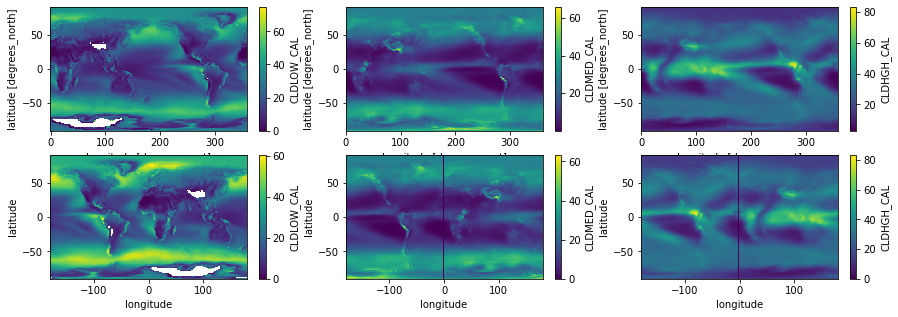

In [36]:
fig,axs = plt.subplots(2,3,figsize=(15,5))

cam4_caliop_cll.plot(ax=axs[0,0])
cam4_caliop_cll_interp['CLDLOW_CAL'].plot(ax=axs[1,0])

cam5_caliop_clm.plot(ax=axs[0,1])
cam5_caliop_clm_interp['CLDMED_CAL'].plot(ax=axs[1,1])

cam5_caliop_clh.plot(ax=axs[0,2])
cam5_caliop_clh_interp['CLDHGH_CAL'].plot(ax=axs[1,2])

### Define function for calculating relevant values

In [37]:
def calculate(cntl,test):
    """Calculate Taylor statistics for making taylor diagrams."""
    
    _cntl = add_weights(cntl)
    wgt = np.array(_cntl['cell_weight'])
    
    # calculate sums and means
    sumwgt = np.sum(wgt)
    meantest = np.sum(wgt*test)/sumwgt
    meancntl = np.sum(wgt*cntl)/sumwgt

    # calculate variances
    stdtest = (np.sum(wgt*(test-meantest)**2.0)/sumwgt)**0.5
    stdcntl = (np.sum(wgt*(cntl-meancntl)**2.0)/sumwgt)**0.5

    # calculate correlation coefficient
    ccnum = np.sum(wgt*(test-meantest)*(cntl-meancntl))
    ccdem = sumwgt*stdtest*stdcntl
    corr = ccnum/ccdem

    # calculate variance ratio
    ratio = stdtest/stdcntl

    # calculate bias
    bias = (meantest - meancntl)/np.abs(meancntl)
    #self.bias = meantest - meancntl

    # calculate centered pattern RMS difference
    try:
        rmssum = np.sum(wgt*((test-meantest)-(cntl-meancntl))**2.0)
        
    except:
        print(((test-meantest)-(cntl-meancntl)).shape)
        print(((test-meantest)-(cntl-meancntl)).lat)
        print(((test-meantest)-(cntl-meancntl)).lon)
    rmserr = (rmssum/sumwgt)**0.5
    rmsnorm = rmserr/stdcntl
    
#     return corr,ratio,bias,rmsnorm
    return bias,corr,rmsnorm,ratio

### Calculate Taylor-relevant values

#### Set-up

In [38]:
# Control names dictionary (i.e. observations)
cntlnames = {
        'CLDLOW_CAL': caliop_low_mean,
        'CLDMED_CAL': caliop_mid_mean,
        'CLDHGH_CAL': caliop_hgh_mean,
    }

# Case names
testnames = ('CAM4','CAM5')
testmetrics = {'CLDLOW_CAL':[cam4_caliop_cll_interp,cam5_caliop_cll_interp],
               'CLDMED_CAL':[cam4_caliop_clm_interp,cam5_caliop_clm_interp],
               'CLDHGH_CAL':[cam4_caliop_clh_interp,cam5_caliop_clh_interp]}
testcolors = ('SkyBlue','Firebrick')

### Calculate

In [40]:
varnames = ['CLDLOW_CAL','CLDMED_CAL','CLDHGH_CAL']

nvars = 3; ntest = 2;
cc = np.zeros([nvars,ntest])
ratio = np.zeros([nvars,ntest])
bias = np.zeros([nvars,ntest])

for ivar,var in enumerate(varnames): # iterate over the variables for a specific Taylor plot
    
    # Select observational dataarray:
    obs_da = cntlnames[var]
    obs_ds = obs_da        
    
    for itest,(name,metric) in enumerate(zip(testnames,testmetrics[var])): # iterate over the models to test/plot
        # Time average:
        test_ds = metric[var]
        
        # Calculate Taylor diagram relevant variables:
        _bias,_corr,_rmsnorm,_ratio = calculate(obs_ds,test_ds)
        
        cc[ivar,itest] = _corr
        ratio[ivar,itest] = _ratio
        bias[ivar,itest] = _bias
        
#         print(bias,corr,rmsnorm,ratio)

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/ch

In [41]:
# Fix fonts
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 10
mpl.rcParams['text.usetex'] = True

### Plot

#### The MISR values appear to be wrong.

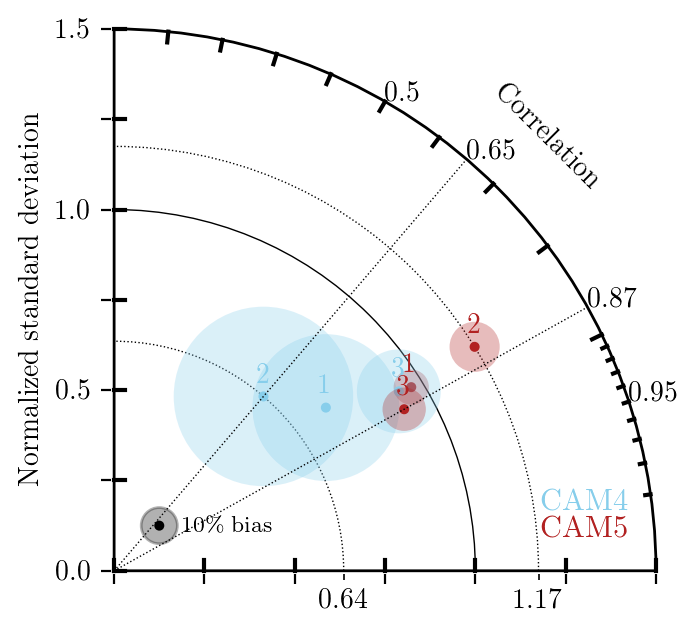

In [42]:
figure = plt.figure(figsize=(8,8))
figure.set_dpi(200)
testcolors = ('SkyBlue','Firebrick')

ax = figure.add_subplot(2,2,1,frameon=False)

taylor_diagram = taylor.Taylor_diagram(
        ax,cc,ratio,bias,
        casecolors=testcolors,
        varlabels=range(1,len(varnames)+1),
        )

# Reference bias bubbles, wut is this?
ref_bias = 0.1 # This is a 10% bias reference bubble in the lower-left corner
yloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
xloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
circle = patches.Circle(
        (xloc,yloc),ref_bias/2.0,
        color="black",
        alpha=0.30,
    )
ax.add_patch(circle)

# Reference bias bubble points - centered at the reference bubble
circle = patches.Circle(
        (xloc,yloc),0.01,
        color="black",
    )
ax.add_patch(circle)

# Reference bias text
ax.text(
        xloc+ref_bias/2.0 + 0.01*taylor_diagram.xymax,yloc,
        "%.0f%s bias"%(ref_bias*100,r"\%"),
        color="Black",
        fontsize=8,
        horizontalalignment="left",
        verticalalignment="center"
    )

# Case labels
xloc = taylor_diagram.xymax*0.95
yloc = taylor_diagram.xymax*0.05
dy = taylor_diagram.xymax*0.05
for itest,testname in enumerate(testnames[::-1]):
    ax.text(
            xloc,yloc+itest*dy, # place these just above the dots
            testname,
            color=testcolors[::-1][itest],
            fontsize=11,
            horizontalalignment="right",
            verticalalignment="bottom",
#             fontweight='bold', # doesn't do anything
        )